In [1]:
import math
from multiprocessing import Pool
import os
import sys
import itertools
import time
import tempfile
import pickle

sys.path.append(os.path.abspath(os.pardir))

%matplotlib inline

import keras
import numpy as np
import pandas as pd
import seaborn as sns

# Metrics
from sklearn.metrics import accuracy_score

# Notebook helper methods
from tdparse import notebook_helper
# Models
from tdparse.models.tdlstm import LSTM, TDLSTM, TCLSTM
# Tokenisers
from tdparse.tokenisers import whitespace, ark_twokenize
# Word Vectors
from tdparse.word_vectors import PreTrained, GloveTwitterVectors, GloveCommonCrawl42
# Get the data
from tdparse.helper import read_config, full_path
from tdparse.parsers import dong, semeval_14

Using TensorFlow backend.


In [2]:
# Load the datasets
dong_train = dong(full_path(read_config('dong_twit_train_data')))
dong_test = dong(full_path(read_config('dong_twit_test_data')))
# Load the word vectors
sswe_path = full_path(read_config('sswe_files')['vo_zhang'])
sswe = PreTrained(sswe_path, name='sswe')
glove_50 = GloveTwitterVectors(50)
glove_100 = GloveTwitterVectors(100)
glove_200 = GloveTwitterVectors(200)

In [ ]:
# General results folder for the method
result_folder = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'results', 'TDLstm'))
# Results folder for trying different pad sizes on different embeddings on different 
# datasets. Where the method is kept the same which is TCLSTM method
pad_size_results_folder = os.path.join(result_folder, 'TCLstm Pad Sizes')
os.makedirs(pad_size_results_folder, exist_ok=True)

def half_average_dataset(dataset):
    '''
    :param dataset: A training dataset
    :type dataset: TargetCollection
    :returns: Half the average sentence length of the given dataset
    :rtype: int
    '''
    sentence_lengths = [len(data['text'].split()) for data in dataset.data()]
    return math.ceil(sum(sentence_lengths) / len(sentence_lengths) / 2)

def pad_size_prediction(embedding_path, pad_size, reproducible, train_data, 
                        test_data, result_path, index_column, tokenizer=ark_twokenize):
    '''
    Works out the preiction of 
    '''

    embedding = None
    with open(embedding_path, 'rb') as embedding_file:
        embedding = pickle.load(embedding_file, encoding='utf-8')
    
    embedding_name = '{}'.format(embedding)
    saved_data = notebook_helper.get_pandas_data(result_path, pad_size, 
                                                 embedding_name, index_column)
    if saved_data is not None:
        return saved_data
    model = TCLSTM(tokenizer, embedding, lower=True, pad_size=pad_size)
    model.fit(train_data.data_dict(), train_data.sentiment_data(), reproducible=True,
              validation_size=0.3, patience=10, epochs=300, verbose=1,
              org_initialisers=True)
    predictions = model.predict(test_data.data_dict())
    score = TCLSTM.score(test_data.sentiment_data(), predictions, accuracy_score)
    notebook_helper.save_pandas_data(result_path, pad_size, 
                                     embedding_name, index_column, score)
    return score

In [4]:
embeddings = [sswe, glove_50, glove_100, glove_200]
embedding_names = ['{}'.format(embedding) for embedding in embeddings]
pad_sizes = [5, 10, half_average_dataset(dong_train), 15, -1]
reproducible = [True]
train_data = [dong_train]
test_data = [dong_test]
pad_results = []

index_column = 'embeddings'
dong_pad_size_res_file = os.path.join(pad_size_results_folder, 'Dong Twitter.csv')
notebook_helper.create_pandas_file(dong_pad_size_res_file, pad_sizes, index_column, 
                                   embedding_names, re_write=False)
for embedding in embeddings:
    with tempfile.NamedTemporaryFile() as embedding_file:
        embedding_path = embedding_file.name
        pickle.dump(embedding, embedding_file)
        pred_params = list(itertools.product([embedding_path], pad_sizes, reproducible, 
                                             train_data, test_data, 
                                             [dong_pad_size_res_file], 
                                             [index_column]))
        for pred_param in pred_params: 
            pad_size_prediction(*pred_param)
        #with Pool(3) as pool:
        #    pool.starmap(pad_size_prediction, pred_params)
        print('Embedding pad results done {}'.format(embedding))
dong_pad_df_results = pd.read_csv(open(dong_pad_size_res_file, 'r'))
dong_pad_df_results = dong_pad_df_results.set_index('embeddings')
dong_pad_df_results

Embedding pad results done sswe
Embedding pad results done glove twitter 50d
Embedding pad results done glove twitter 100d
Embedding pad results done glove twitter 200d


,5,10,9,15,-1
embeddings,,,,,
sswe,0.606936,0.628613,0.614162,0.647399,0.660405
glove twitter 50d,0.644509,0.645954,0.667630,0.654624,0.609827
glove twitter 100d,0.663295,0.670520,0.661850,0.674855,0.624277
glove twitter 200d,0.643064,0.673410,0.669075,0.669075,0.635838


In [6]:
del embeddings
del embedding_names

semeval_14_rest_train = semeval_14(full_path(read_config('semeval_2014_rest_train')))
semeval_14_rest_test = semeval_14(full_path(read_config('semeval_2014_rest_test')))
train_data = [semeval_14_rest_train]
test_data = [semeval_14_rest_test]
# We also use the Glove 300d vectors trained on the common crawl and used in the following paper
# http://www.anthology.aclweb.org/D/D16/D16-1021.pdf
glove_300 = GloveCommonCrawl42()
embedding = glove_300
embedding_names = ['{}'.format(embedding)]
pad_sizes = [5, 10, half_average_dataset(semeval_14_rest_train), 15, -1]

index_column = 'embeddings'
sem_rest_pad_size_res_file = os.path.join(pad_size_results_folder, 'Semeval Restaurant 14.csv')
notebook_helper.create_pandas_file(sem_rest_pad_size_res_file, pad_sizes, index_column, 
                                   embedding_names, re_write=False)
with tempfile.NamedTemporaryFile() as embedding_file:
    embedding_path = embedding_file.name
    pickle.dump(embedding, embedding_file)
    pred_params = list(itertools.product([embedding_path], pad_sizes, reproducible, 
                                         train_data, test_data, 
                                         [sem_rest_pad_size_res_file], 
                                         [index_column], [whitespace]))
    for pred_param in pred_params: 
        pad_size_prediction(*pred_param)
sem_rest_pad_df_results = pd.read_csv(open(sem_rest_pad_size_res_file, 'r'))
sem_rest_pad_df_results = sem_rest_pad_df_results.set_index('embeddings')
sem_rest_pad_df_results

Train on 2521 samples, validate on 1081 samples
Epoch 1/300
2521/2521 [==============================] - 104s 41ms/step - loss: 0.9795 - acc: 0.5982 - val_loss: 0.9552 - val_acc: 0.6004
Epoch 2/300
2521/2521 [==============================] - 99s 39ms/step - loss: 0.9465 - acc: 0.6010 - val_loss: 0.9414 - val_acc: 0.6004
Epoch 3/300
2521/2521 [==============================] - 94s 37ms/step - loss: 0.9336 - acc: 0.6010 - val_loss: 0.9298 - val_acc: 0.6004
Epoch 4/300
2521/2521 [==============================] - 96s 38ms/step - loss: 0.9223 - acc: 0.6013 - val_loss: 0.9203 - val_acc: 0.6004
Epoch 5/300
2521/2521 [==============================] - 96s 38ms/step - loss: 0.9122 - acc: 0.6017 - val_loss: 0.9117 - val_acc: 0.6004
Epoch 6/300
2521/2521 [==============================] - 96s 38ms/step - loss: 0.9035 - acc: 0.6045 - val_loss: 0.9031 - val_acc: 0.6041
Epoch 7/300
2521/2521 [==============================] - 95s 37ms/step - loss: 0.8947 - acc: 0.6109 - val_loss: 0.8962 - val_acc:

2521/2521 [==============================] - 301s 119ms/step - loss: 0.8443 - acc: 0.6374 - val_loss: 0.8475 - val_acc: 0.6272
Epoch 15/300
2521/2521 [==============================] - 301s 120ms/step - loss: 0.8366 - acc: 0.6414 - val_loss: 0.8412 - val_acc: 0.6383
Epoch 16/300
2521/2521 [==============================] - 302s 120ms/step - loss: 0.8275 - acc: 0.6438 - val_loss: 0.8378 - val_acc: 0.6420
Epoch 17/300
2521/2521 [==============================] - 304s 121ms/step - loss: 0.8184 - acc: 0.6541 - val_loss: 0.8295 - val_acc: 0.6420
Epoch 18/300
2521/2521 [==============================] - 302s 120ms/step - loss: 0.8105 - acc: 0.6553 - val_loss: 0.8249 - val_acc: 0.6392
Epoch 19/300
2521/2521 [==============================] - 298s 118ms/step - loss: 0.8004 - acc: 0.6601 - val_loss: 0.8263 - val_acc: 0.6355
Epoch 20/300
2521/2521 [==============================] - 303s 120ms/step - loss: 0.7923 - acc: 0.6557 - val_loss: 0.8196 - val_acc: 0.6512
Epoch 21/300
2521/2521 [=========

,5,10,9,15,-1
embeddings,,,,,
glove 300d 42B common crawl,0.699107,0.683036,0.705357,0.683929,0.679464


In [ ]:
semeval_14_lap_train = semeval_14(full_path(read_config('semeval_2014_lap_train')))
semeval_14_lap_test = semeval_14(full_path(read_config('semeval_2014_lap_test')))
train_data = [semeval_14_lap_train]
test_data = [semeval_14_lap_test]

pad_sizes = [5, half_average_dataset(semeval_14_lap_train), 15, -1]

index_column = 'embeddings'
sem_lap_pad_size_res_file = os.path.join(pad_size_results_folder, 'Semeval Laptop 14.csv')
notebook_helper.create_pandas_file(sem_lap_pad_size_res_file, pad_sizes, index_column, 
                                   embedding_names, re_write=False)
with tempfile.NamedTemporaryFile() as embedding_file:
    embedding_path = embedding_file.name
    pickle.dump(embedding, embedding_file)
    pred_params = list(itertools.product([embedding_path], pad_sizes, reproducible, 
                                         train_data, test_data, 
                                         [sem_lap_pad_size_res_file], 
                                         [index_column], [whitespace]))
    for pred_param in pred_params: 
        pad_size_prediction(*pred_param)
sem_lap_pad_df_results = pd.read_csv(open(sem_lap_pad_size_res_file, 'r'))
sem_lap_pad_df_results = sem_lap_pad_df_results.set_index('embeddings')
sem_lap_pad_df_results

# LSTM
This is an implementation of the LSTM model that is shown in [Tang et al. paper](https://aclanthology.info/papers/C16-1311/c16-1311).

The LSTM is a single LSTM layer that outputs to a softmax function. The LSTM hidden layer dimension is the same as the embedding layer dimension. The optimiser is Stochastic Gradient Descent with a learning rate of 0.01.

The number of epochs to run the model is unknown and Early Stopping is not mentioned in the paper. As we do not know the number of epochs used we are going to use Early Stopping with a patience of 10.

This notebook is going to perform the following experiments:
1. The affect of lower casing the words - This should cause some affect as all of the word embeddings only contain lower cased words.
2. Tokeniser - the affect of using a simple Whitespace tokeniser and a data set specific tokeniser [ark tokenizer](https://www.cs.cmu.edu/~ark/TweetNLP/gimpel+etal.acl11.pdf) for Twitter data
3. Different Validation set size affect - As we are using Early Stopping we require a validation set within the training data therefore we are going to see the affect of this on the Test set.


All of the experiments above will be performed with the [Sentiment Specfic Word Embeddings (SSWE)](https://www.aclweb.org/anthology/P14-1146) which are 50 dimension word embeddings which we ctreated by jointly learning sentiment and semantics.

After these experiments we will use the best settings to run over all the word embeddings used in the paper:
1. SSWE 50 Dimensions In the paper these are called SSWE -u
2. Twitter Glove 50 Dimensions
3. Twitter Glove 100 Dimensions
4. Twitter Glove 200 Dimensions

All of the experiments above will be performed on [Dong et al. Twitter dataset](https://aclanthology.info/papers/P14-2009/p14-2009) as used in the original paper. The dataset we used can be found [here](https://github.com/bluemonk482/tdparse/tree/master/data/lidong), this was used as the original dataset had been pre-processed thus containg symbols such as: -LRB- and -RRB-

The Twitter glove vectors can be found [here](https://nlp.stanford.edu/projects/glove/)

### Affect of initialiser

In [4]:
tclstm_model = TCLSTM(ark_twokenize, sswe, lower=True)
tclstm_model.fit(dong_train.data_dict(), dong_train.sentiment_data(), reproducible=True,
                 validation_size=0.3, patience=10, epochs=300, verbose=0,
                 org_initialisers=True)
predictions_keras = tclstm_model.predict(dong_test.data_dict())
score_keras = TCLSTM.score(dong_test.sentiment_data(), predictions_keras, accuracy_score)

tclstm_model.fit(dong_train.data_dict(), dong_train.sentiment_data(), reproducible=True,
               validation_size=0.3, patience=10, epochs=300, verbose=0,
               org_initialisers=True)
predictions_original = tclstm_model.predict(dong_test.data_dict())
score_original = TCLSTM.score(dong_test.sentiment_data(), predictions_original, accuracy_score)

in here


### Affect of lower casing

In [ ]:
lower_case_options = [True, False]
lower_case_results = {}
for lower_case_option in lower_case_options:
    tclstm_model = TCLSTM(ark_twokenize, glove_200, lower=lower_case_option)
    tclstm_model.fit(dong_train.data_dict(), dong_train.sentiment_data(), reproducible=True,
                     validation_size=0.3, patience=10, epochs=300, verbose=0,
                     org_initialisers=True)
    predictions = tclstm_model.predict(dong_test.data_dict())
    score = TCLSTM.score(dong_test.sentiment_data(), predictions, accuracy_score)
    lower_case_results['Lower case option {}'.format(lower_case_option)] = score
pd.DataFrame(lower_case_results, index=['LSTM'])

### The affect of the tokeniser

In [ ]:
tokenisers = [whitespace, ark_twokenize]
tokeniser_results = {}
for tokeniser in tokenisers:
    tclstm_model = TCLSTM(tokeniser, glove_200, lower=True)
    tclstm_model.fit(dong_train.data_dict(), dong_train.sentiment_data(), reproducible=True,
                     validation_size=0.1, patience=10, epochs=300, verbose=0,
                     org_initialisers=True)
    predictions = tclstm_model.predict(dong_test.data_dict())
    score = TCLSTM.score(dong_test.sentiment_data(), predictions, accuracy_score)
    tokeniser_results['Tokeniser {}'.format(tokeniser.__name__)] = score
pd.DataFrame(tokeniser_results, index=['LSTM'])

### Different Validation set sizes

Using 5 processors uses around ~22GB of RAM this is due to the size of the Glove Vectors.

In [ ]:
def validation_prediction(train_data, test_data, embedding_path, validation_size, reproducible):
    embedding = None
    with open(embedding_path, 'rb') as embedding_file:
        embedding = pickle.load(embedding_file, encoding='utf-8')
    print('start {}'.format(embedding))
    pad_size = half_average_dataset(train_data)
    tclstm_model = TCLSTM(ark_twokenize, embedding, lower=True, pad_size=pad_size)
    tclstm_model.fit(train_data.data_dict(), train_data.sentiment_data(), reproducible=reproducible,
                     validation_size=validation_size, patience=10, epochs=300, verbose=0,
                     org_initialisers=True)
    predictions = tclstm_model.predict(test_data.data_dict())
    embedding_name = '{}'.format(embedding)
    score = TCLSTM.score(test_data.sentiment_data(), predictions, accuracy_score)
    print('end {}'.format(embedding))
    print('score {}'.format(score))
    return score

def repeated_results(n_results, n_jobs, train_data, test_data, embedding, validation_size):
    '''
    n_results number of result samples to produce. n_jobs number of 
    processors to use the more processors the more memory required 
    10 = ~36GB Ram for Glove 50 memory very much depends on the word 
    vectors and Glove vectors are large. embedding the embedding to 
    use e.g. Glove 50. validation size, size of the validation 
    set e.g. 0.3
    '''
    batch_size = math.ceil(n_results / n_jobs)
    train_data = [train_data]
    test_data = [test_data]
    reproducible = [False]
    results = []
    print('batch size {} jobs {}'.format(batch_size, n_jobs))
    for i in range(batch_size):
        num_results = n_jobs
        left_to_process = n_results - len(results)
        if n_jobs > left_to_process:
            num_results = left_to_process
        with tempfile.NamedTemporaryFile() as embedding_file:
            embedding_path = embedding_file.name
            pickle.dump(embedding, embedding_file)
            val_pred_params = list(itertools.product(train_data, test_data, [embedding_path], 
                                                     [validation_size] * num_results, reproducible))
            with Pool(n_jobs) as pool:
                results.extend(pool.starmap(validation_prediction, val_pred_params))
                print('done')
    return results


results_30_glove_200 = repeated_results(60, 2, dong_train, dong_test, glove_200, 0.3)
results_30_sswe = repeated_results(60, 3, dong_train, dong_test, sswe, 0.3)
#results_30_glove_100 = repeated_results(30, 3, dong_train, dong_test, glove_100, 0.3)
#results_30_glove_50 = repeated_results(30, 3, dong_train, dong_test, glove_50, 0.3)


batch size 30 jobs 2
start glove twitter 200d
start glove twitter 200d
end glove twitter 200d
score 0.6791907514450867
end glove twitter 200d
score 0.6661849710982659
done
start glove twitter 200d
start glove twitter 200d
end glove twitter 200d
score 0.6604046242774566
end glove twitter 200d
score 0.6647398843930635
done
start glove twitter 200d
start glove twitter 200d


In [8]:
results_30_sswe

NameError: name 'results_30_sswe' is not defined

In [12]:
import json
repeated_results_folder = os.path.join(result_folder, 'TCLstm Repeated Results')
os.makedirs(repeated_results_folder, exist_ok=True)
repeated_results_file = os.path.join(repeated_results_folder, 'Glove 200.json')
with open(repeated_results_file, 'w') as fp:
    json.dump(results_30_glove_200, fp)
repeated_results_file = os.path.join(repeated_results_folder, 'sswe.json')
with open(repeated_results_file, 'w') as fp:
    json.dump(results_30_sswe, fp)

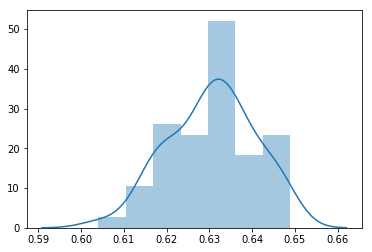

In [8]:
import seaborn as sns
sns.distplot(results_30_sswe)

In [9]:
tclstm_model = TCLSTM(ark_twokenize, sswe, lower=True)
tclstm_model.fit(dong_train.data_dict(), dong_train.sentiment_data(), reproducible=True,
                 validation_size=0.3, patience=10, epochs=300, verbose=0,
                 org_initialisers=True, lstm_dimension=100)
predictions_keras = tclstm_model.predict(dong_test.data_dict())
score_keras = TCLSTM.score(dong_test.sentiment_data(), predictions_keras, accuracy_score)

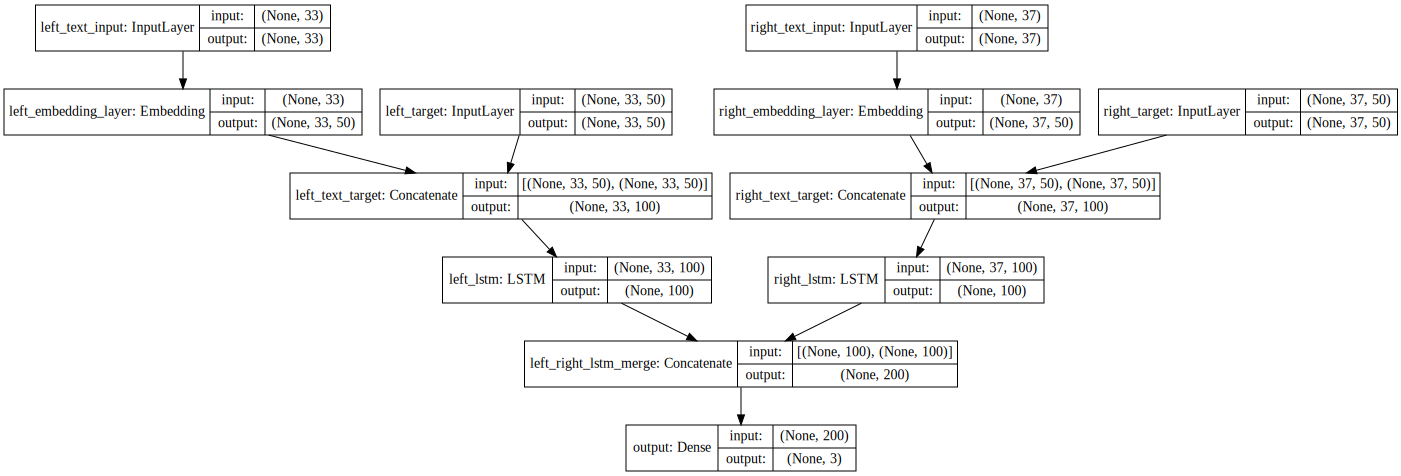

In [10]:
tclstm_model.visulaise()

In [11]:
score_keras

0.66040462427745661

In [9]:
results_df = pd.DataFrame(np.zeros((len(embeddings), len(validation_sizes))))
results_df.index = ['{}'.format(embedding) for  embedding in embeddings]
results_df.columns = ['{}'.format(int(val_size * 100)) for val_size in validation_sizes]
for result in results:
    embedding_name, val_size, score = result
    results_df[val_size][embedding_name] = score
round(results_df * 100, 2)

TypeError: 'numpy.float64' object is not iterable

As we can see from the results above the validation set matters however we can see 20% validation appears to be the worse. I should imagine this is due to the 30 and 15% sets containing data that is more representive of the test data therefore allowing the model to find features/weights that can better sperate the classes within the test data.

However it could just be due to the random seed we used and that the validation split that was found is just not very reprenative of the test data. We think this is the case as it is unusall that a smaller sample size 0.1 is better representative of the test data than a large sample size 0.2. Therefore below we use the Glove 50 dimension vectors and re-run the experiment using a different random validation split each time to see the affect over a larger sample size to see what the affect of validation size is with a larger sample size:

In [ ]:
def validation_prediction(train_data, test_data, embedding, validation_size, reproducible):
    print('start {}'.format(embedding))
    pad_size = half_average_dataset(train_data)
    tclstm_model = TCLSTM(ark_twokenize, embedding, lower=True, pad_size=pad_size)
    tclstm_model.fit(train_data.data_dict(), train_data.sentiment_data(), reproducible=reproducible,
                     validation_size=validation_size, patience=10, epochs=300, verbose=0,
                     org_initialisers=True)
    predictions = tclstm_model.predict(test_data.data_dict())
    embedding_name = '{}'.format(embedding)
    score = TCLSTM.score(test_data.sentiment_data(), predictions, accuracy_score)
    print('end {}'.format(embedding))
    return score
def val_pred_wrapper(train_data, test_data, embedding, validation_size, reproducible):
    score = validation_prediction(embedding, validation_size, reproducible)
    return ('{}'.format(embedding), 
            'Validation Size {}%'.format(int(validation_size * 100)),
            score)

train_data = [dong_train]
test_data = [dong_test]
embeddings = [sswe, glove_50, glove_100, glove_200]
validation_sizes = [0.3, 0.2, 0.1]
reproducible = [True]
val_pred_params = list(itertools.product(train_data, test_data, embeddings, validation_sizes, reproducible))
results = None
time_taken = time.time()
#print(val_pred_wrapper(*val_pred_params[0]))
with Pool(10) as pool:
    results = pool.starmap(val_pred_wrapper, val_pred_params)
time_taken = time.time() - time_taken
time_taken

start sswe
start sswe
start sswe
start glove twitter 50d
start glove twitter 50d
end glove twitter 50d
start glove twitter 50d
end sswe
start glove twitter 100d
end glove twitter 50d
end sswe
start glove twitter 100d
start glove twitter 100d
end sswe
start glove twitter 200d
end glove twitter 50d
start glove twitter 200d
end glove twitter 100d
start glove twitter 200d
end glove twitter 100d
end glove twitter 100d


In [ ]:
results_20 = repeated_results(100, 3, glove_200, 0.2)

In [ ]:
results_10 = repeated_results(100, 3, glove_200, 0.1)

In [9]:
results_30

NameError: name 'results_30' is not defined

In [ ]:
results_repeated_df = pd.DataFrame({'Validation 10%' : results_10,
                                    'Validation 20%' : results_20,
                                    'Validation 30%' : results_30})
results_repeated_df = round(results_repeated_df * 100, 2)
ax = sns.boxplot(data=results_repeated_df)
ax = sns.swarmplot(data=results_repeated_df, color=".25")
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Comparison of Validation Set Sizes')
ax

In [ ]:
results_repeated_summary = results_repeated_df.describe().T.round(2)
results_repeated_summary

As we can see the different between the two validation sets is slight. The 30% has a higher minimum and maximum value as well as it deviate less suggesting that on average this set better represents the test data. Even though the training set of the LSTM will be 10% lower it is worth having a better validation set for training the LSTM algorthim.